In [2]:
#Add All High-Impact Features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (ensure you place your CSV file in the data/raw/ folder)
df = pd.read_csv('../data/cleaned_data.csv')
print(df.head())


   credit_score  gender  age  tenure    balance  products_number  credit_card  \
0           619       0   42       2       0.00                1            1   
1           608       0   41       1   83807.86                1            0   
2           502       0   42       8  159660.80                3            1   
3           699       0   39       1       0.00                2            0   
4           850       0   43       2  125510.82                1            1   

   active_member  estimated_salary  churn  country_Germany  country_Spain  \
0              1         101348.88      1                0              0   
1              1         112542.58      0                0              1   
2              0         113931.57      1                0              0   
3              0          93826.63      0                0              0   
4              1          79084.10      0                0              1   

   age_outlier  product_heavy_user  low_credit_sco

In [3]:
# 1. Balance-to-Salary Ratio
# ✅ Importance: Shows how much of their income customers hold in the bank
# ❓ Question: Are customers who keep more of their money in the bank less likely to churn?
df['balance_salary_ratio'] = df['balance'] / (df['estimated_salary'] + 1)

# 2. High Value Customer Flag
# ✅ Importance: Identifies customers with high balance AND many products (valuable segment)
# ❓ Question: Are we losing high-value customers with multiple services?
df['is_high_value'] = ((df['balance'] > 100000) & (df['products_number'] > 2)).astype(int)

# 3. Age-to-Tenure Ratio
# ✅ Importance: Normalizes tenure based on age to capture early or late loyalty
# ❓ Question: Are older customers with short tenure more likely to churn?
df['age_tenure_ratio'] = df['age'] / (df['tenure'] + 1)

# 4. Engagement Score
# ✅ Importance: Combines activeness, credit card usage, and number of products
# ❓ Question: Is low engagement (few products, not active) a churn signal?
df['engagement_score'] = (
    df['active_member'] * 2 +  # Active users weighted more
    df['credit_card'] +
    df['products_number']
)

# 5. Loyalty Score
# ✅ Importance: Shows how long they've been with the bank relative to their age
# ❓ Question: Have they been loyal since early in their life or just recently?
df['loyalty_score'] = df['tenure'] / (df['age'] + 1)

# 6. Salary per Product
# ✅ Importance: Measures income spread across bank services
# ❓ Question: Do high-income customers use fewer products (and risk churning)?
df['salary_per_product'] = df['estimated_salary'] / (df['products_number'] + 1)

# 7. Balance per Product
# ✅ Importance: Measures how deeply invested a customer is per service
# ❓ Question: Are customers with high balance but few products still engaged?
df['balance_per_product'] = df['balance'] / (df['products_number'] + 1)

# 8. Underbanked Flag
# ✅ Importance: Flags high earners using only 1 product — a possible upsell or churn risk
# ❓ Question: Are we failing to retain wealthy customers with low product adoption?
median_salary = df['estimated_salary'].median()
df['is_underbanked'] = ((df['estimated_salary'] > median_salary) & (df['products_number'] == 1)).astype(int)

# 9. Product Heavy User Flag
# ✅ Importance: Identifies customers using the maximum number of services
# ❓ Question: Are heavy users loyal or likely to leave if expectations aren’t met?
df['product_heavy_user'] = (df['products_number'] == df['products_number'].max()).astype(int)

# 10. Low Credit Score Flag
# ✅ Importance: Customers with very low scores (FICO < 400) are high risk
# ❓ Question: Are poor-credit customers churning more (due to restrictions or service denials)?
df['low_credit_score'] = (df['credit_score'] < 400).astype(int)

C:\Users\adixb\AppData\Local\Temp\ipykernel_134420\2020103302.py:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\adixb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


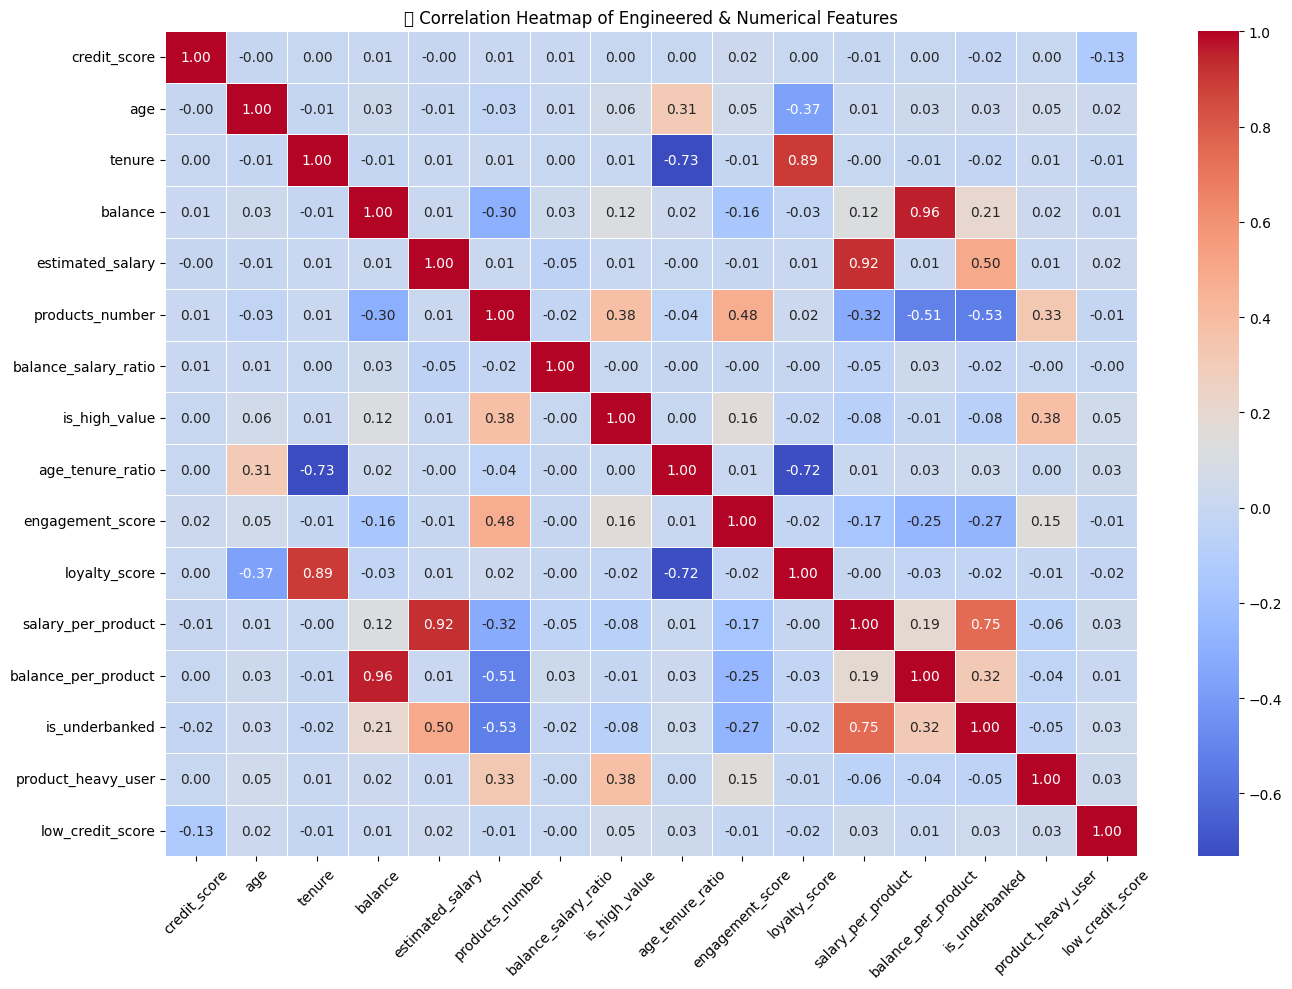

🔗 Highly Correlated Feature Pairs (|correlation| > 0.8):
loyalty_score ⟷ tenure = 0.89
salary_per_product ⟷ estimated_salary = 0.92
balance_per_product ⟷ balance = 0.96


In [4]:
# #Check Feature Correlation
# Let’s plot a heatmap to visually inspect correlation between these new features and existing ones.

# Step 1: Select numerical + engineered features to analyze
features_to_check = [
    'credit_score', 'age', 'tenure', 'balance', 'estimated_salary', 'products_number',
    'balance_salary_ratio', 'is_high_value', 'age_tenure_ratio',
    'engagement_score', 'loyalty_score', 'salary_per_product',
    'balance_per_product', 'is_underbanked', 'product_heavy_user', 'low_credit_score'
]

# Step 2: Compute correlation matrix
corr_matrix = df[features_to_check].corr()

# Step 3: Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("🔍 Correlation Heatmap of Engineered & Numerical Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 4: Automatically list highly correlated pairs (above 0.8, excluding self-pairs)
threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], round(corr_value, 2)))

# Step 5: Display results
print("🔗 Highly Correlated Feature Pairs (|correlation| > 0.8):")
for a, b, corr in high_corr_pairs:
    print(f"{a} ⟷ {b} = {corr}")


In [5]:
# Drop features that are highly correlated and may cause multicollinearity
features_to_drop = ['salary_per_product', 'balance_per_product']

df.drop(columns=features_to_drop, inplace=True)

# ✅ Optional: Confirm they've been removed
print("Remaining columns after dropping:")
print(df.columns)

Remaining columns after dropping:
Index(['credit_score', 'gender', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'churn',
       'country_Germany', 'country_Spain', 'age_outlier', 'product_heavy_user',
       'low_credit_score', 'balance_salary_ratio', 'is_high_value',
       'age_tenure_ratio', 'engagement_score', 'loyalty_score',
       'is_underbanked'],
      dtype='object')


In [8]:
df.head()


,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,...,country_Spain,age_outlier,product_heavy_user,low_credit_score,balance_salary_ratio,is_high_value,age_tenure_ratio,engagement_score,loyalty_score,is_underbanked
0,619,0,42,2,0.00,1,1,1,101348.88,1,...,0,0,0,0,0.000000,0,14.000000,4,0.046512,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0,...,1,0,0,0,0.744670,0,20.500000,3,0.023810,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,...,0,0,0,0,1.401362,1,4.666667,4,0.186047,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,...,0,0,0,0,0.000000,0,19.500000,2,0.025000,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,...,1,0,0,0,1.587035,0,14.333333,4,0.045455,0


In [9]:
corr_matrix = df.corr(numeric_only=True)
# Select upper triangle of correlation matrix
upper = corr_matrix.where(
    ~np.tril(np.ones(corr_matrix.shape)).astype(bool)
)

# Find index of feature columns with correlation greater than 0.85 (tunable threshold)
to_drop = [
    column for column in upper.columns if any(upper[column].abs() > 0.85)
]

print("Highly correlated features to drop:", to_drop)

Highly correlated features to drop: ['loyalty_score']


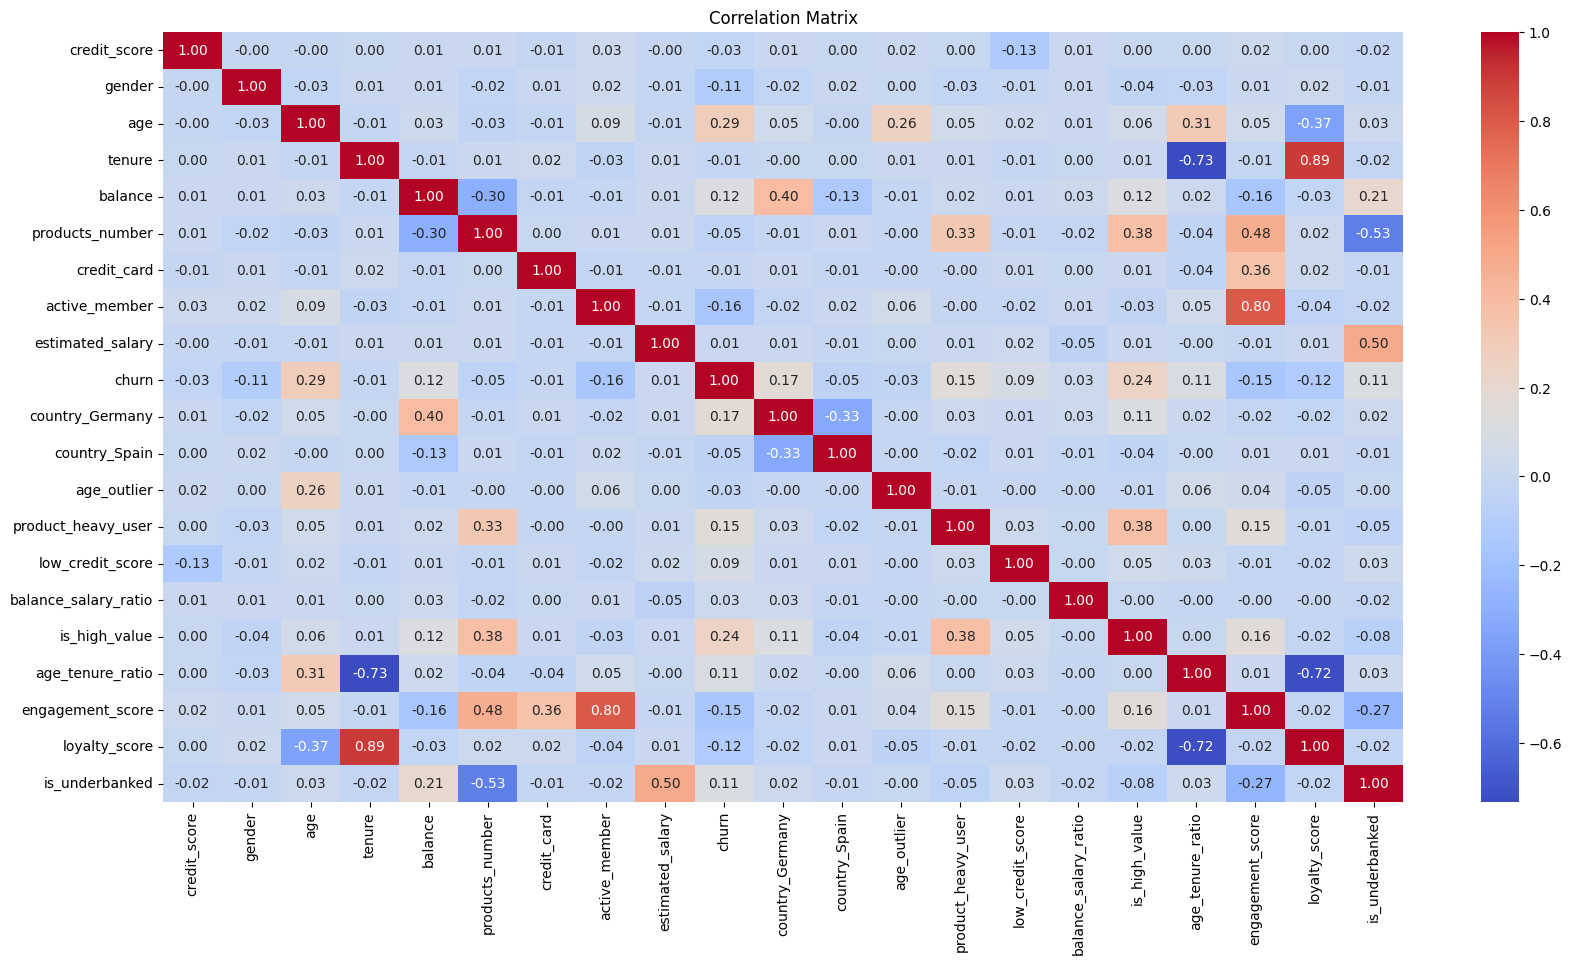

In [10]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [11]:
df.to_csv('../data/featured_data.csv', index=False)

In [ ]:
# #completed
# Cleaned data
# One-hot encoded or removed categorical variables
# Engineered new features
# Removed highly correlated ones
# Confirmed all data is model-ready